<h3>The goal of this notebook is to initially explore the data before I choose to use this as a dataset for my next capstone. There are couple things I'm looking for</h3> 
<ul>
    <li>Figure out what is there and what isn't</li>
    <li>Is there other data I may want to download to supplement this?</li>
</ul>

<h3> After that, I'll look into possible methods of building recommender systems and link the articles here</h3>

In [1]:
## load imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
## Load users file and display first 5 rows
users_df = pd.read_csv('../data/raw/BX-Users.csv',sep=';',encoding='8859')
users_df.head(5)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


<h3> It looks like we have 3 columns </h3>
<UL>
<LI>a unique column "User-ID"</LI>
<LI>a location column that seems to have city, state/province, & country</li>
<LI>Age</LI>
</UL>
<h3> First, I'll look for uniqueness in User-ID and any missing data in the other columns (it looks like we'll at least have some in the age columns</h3>

In [3]:
users_df['User-ID'].value_counts()[:5]

2047      1
66165     1
119407    1
76400     1
74353     1
Name: User-ID, dtype: int64

<h3> Since the first 5 rows have a value count of 1, then they are all unique values as expected </h3>

In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
User-ID     278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


<h3> At a glance, it seems that Age is the only column with missing data and it's missing about 40% of data. This may be worth dropping as filling it may not make sense. I'll deep dive more into Location to make sure there are no ',,,' values</h3>

In [5]:
## creat a list of list of values from the Location series then create a dictionary counting how many of each exist.
## if there is an overwhelming amount in a standard format, we may be able to parse this out further.

from collections import defaultdict # - To reduce code of codifing a new dict from counts of Location Lengths

# Split the Location series by ,
loc_split = users_df['Location'].str.split(',')

# initialize the default dict
d_dict = defaultdict(int)

# build counts in default dict
for val in loc_split.values.tolist():
    d_dict[len(val)] += 1

# print Results from default dict
print('Length of split series and % of rows in the series with this length')
for key, val in zip(d_dict.keys(),d_dict.values()):
    print('Key: {0}, % of data: {1:.6f}'.format(key,(val/len(users_df))))

Length of split series and % of rows in the series with this length
Key: 3, % of data: 0.994585
Key: 4, % of data: 0.005081
Key: 5, % of data: 0.000258
Key: 2, % of data: 0.000004
Key: 8, % of data: 0.000007
Key: 6, % of data: 0.000039
Key: 7, % of data: 0.000014
Key: 1, % of data: 0.000004
Key: 9, % of data: 0.000007


<h3>It seems over 99% of the rows contain three splits with the potential of city, state, country. There will probably be missing data in there as well but it's a great place to think about using these as features</h3>

<h3>Next, lets look at the books</h3>

In [6]:
## Load ratings file and display first 5 rows
books_df = pd.read_csv('../data/raw/BX-Books.csv',sep=';',quoting=csv.QUOTE_ALL,)
books_df.head()

ParserError: Error tokenizing data. C error: Expected 8 fields in line 6452, saw 9


<h3>It looks like there was an issue with line 6452 in the data. Let's open this and figure out what's going on</h3> 

In [7]:
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        if i == 158566:
            print(line)

"0883966883";"Thoughts to Share With a Wonderful Friend: A Gift That Will Live Forever in the Heart of a Friend (\"Language of)";"Gwendolyn Gray";"2003";"Blue Mountain Arts";"http://images.amazon.com/images/P/0883966883.01.THUMBZZZ.jpg";"http://images.amazon.com/images/P/0883966883.01.MZZZZZZZ.jpg";"http://images.amazon.com/images/P/0883966883.01.LZZZZZZZ.jpg"



<h3> There was an ampersand encoded as &amp;. I'll set some code to change those back to & </h3>

In [8]:
d = defaultdict(list)
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = line.replace('&amp;','&').split(';')

In [9]:
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
books_df.head()

AssertionError: 8 columns passed, passed data had 14 columns

<h3> There was still an error with the data. I'll replace the separator from ; to || by using regex to look for ";" and replace only that code with the new separator </h3>

In [10]:
import re
d = defaultdict(list)

strtofind = r'";"'
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = re.sub(strtofind,'||',line.replace('&amp;','&')).replace('"','').replace('\n','').split('||')
        
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
3,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
4,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
5,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [11]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271379 entries, 1 to 271379
Data columns (total 8 columns):
ISBN                   271379 non-null object
Book-Title             271379 non-null object
Book-Author            271379 non-null object
Year-Of-Publication    271379 non-null object
Publisher              271379 non-null object
Image-URL-S            271379 non-null object
Image-URL-M            271379 non-null object
Image-URL-L            271379 non-null object
dtypes: object(8)
memory usage: 18.6+ MB


<h3> There doesn't seem to be any missing data. But i want to dig in further ot see if this is the case. </h3>

In [12]:
### Check Year ###
books_df['Year-Of-Publication'].value_counts().sort_index().head()

0       4619
1376       1
1378       1
1806       1
1897       1
Name: Year-Of-Publication, dtype: int64

<h3>There are a handful of books that do not have a year associated with the publication date. I'll need to think about how to impute these values or exclude these rows</h3>

In [13]:
### Check ISBN ###
books_df['ISBN'].value_counts().sort_index().head(),books_df['ISBN'].value_counts().sort_index().tail()

(0000913154    1
 0001010565    1
 0001046438    1
 0001046713    1
 000104687X    1
 Name: ISBN, dtype: int64, B000234N76    1
 B000234NC6    1
 B00029DGGO    1
 B0002JV9PY    1
 B0002K6K8O    1
 Name: ISBN, dtype: int64)

<h3> First, there doesn't appear to be any duplicate ISBNs. Next I can't seem to find any blanks or coded unkown numbers </h3>

In [14]:
### Check Titles ###
books_df['Book-Title'].sort_values().tail()

151764                     Ã?Â?lpiraten.
67344     Ã?Â?rger mit Produkt X. Roman.
240222               Ã?Â?sterlich leben.
100002             Ã?Â?stlich der Berge.
45304                  Ã?Â?thique en toc
Name: Book-Title, dtype: object

<h3>There were a handfull of titles that are encoded with the characters Ã?Â?. I'll have to think about how to deal with these in the future. Also, i could not find any coded blanks or unknowns with some basic searches.</h3>

In [15]:
### Check Authors ###
books_df['Book-Author'].value_counts().head(11)

Agatha Christie         632
William Shakespeare     567
Stephen King            524
Ann M. Martin           423
Carolyn Keene           373
Francine Pascal         373
Isaac Asimov            330
Nora Roberts            315
Barbara Cartland        307
Charles Dickens         302
Not Applicable (Na )    286
Name: Book-Author, dtype: int64

In [16]:
books_df[books_df['Book-Author'].str.contains('Agatha')]['Book-Author'].value_counts()

Agatha Christie                 632
Agatha Miller, Dame Christie      2
Agatha christie                   1
Agatha Anastasi                   1
Christie Agatha                   1
Agatha Christie Mallowan          1
Agatha Christe                    1
Agatha Chrisitie                  1
Name: Book-Author, dtype: int64

<h3>There is an interesting Not Applicable Author with a fairly high count of titles written. Out side of this I can't find any coded unknowns with a couple basic searches. I should be aware of misspelled author names such as the varies spellings of Agatha Christie.</h3>

In [17]:
books_df['Publisher'].value_counts()

Harlequin                                       7536
Silhouette                                      4220
Pocket                                          3905
Ballantine Books                                3783
Bantam Books                                    3647
Scholastic                                      3160
Simon & Schuster                                2971
Penguin Books                                   2844
Berkley Publishing Group                        2771
Warner Books                                    2727
Penguin USA                                     2717
Harpercollins                                   2526
Fawcett Books                                   2258
Signet Book                                     2070
Random House Inc                                2045
St Martins Pr                                   1953
St. Martin's Press                              1783
Tor Books                                       1704
HarperCollins Publishers                      

<h3>One concern I have is that the names of publisher could be misspelled, abbreviated, or typed slightlty differently. For example, see the publisher Penguin below. While some of the variabliity may be correct to keep like Penguin USA vs Penguin UK, items like penguin books, and penguin could be combined. Or Penguin USA, Penguin USA (PAPER), or PENGUIN U S A</h3>

In [18]:
books_df[books_df['Publisher'].str.contains('Penguin')]['Publisher'].value_counts()

Penguin Books                                             2844
Penguin USA                                               2717
Penguin Books Ltd                                          863
Penguin Putnam~mass                                        318
Penguin Putnam~trade                                       246
Penguin Putnam                                             115
Penguin Uk                                                 109
Penguin                                                     91
Penguin Putnam~childrens Hc                                 85
Penguin USA (Paper)                                         67
Penguin USA (J)                                             59
Penguin Books Australia Ltd                                 51
Penguin Audiobooks                                          49
Viking Penguin Inc                                          46
Penguin Putnam Books for Young Readers                      41
Penguin U S A                                          

<h3>I'd like to explore the images as well. From a survey taken by a non scientific website hints that covers do matter in what a consumer may choose. If this is true, I need to be sure this is taken into account in the recommender system.</h3>

https://www.thebooksmugglers.com/2010/04/cover-matters-the-survey-results.html

In [19]:
import urllib, cv2
url = books_df['Image-URL-L'].iloc[1]

In [20]:
resp = urllib.request.urlopen(url) # Request image data
image = np.asarray(bytearray(resp.read()), dtype="uint8") #codify iamage as an array
image = cv2.imdecode(image, cv2.IMREAD_COLOR) #Decode the image using cv2
#cv2.imshow("Image", image)
#cv2.waitKey(0)

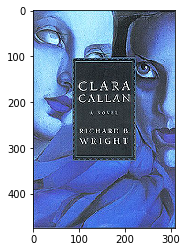

In [21]:
# Show the image
plt.imshow(image)
plt.show()

<h2> Finally, let's look at the ratings file </h2>

In [22]:
ratings_df = pd.read_csv('../data/raw/BX-Book-Ratings.csv',sep=';',encoding='8859',dtype={'Book-Rating':np.float64})

In [23]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [24]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 26.3+ MB


In [25]:
ratings_df.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


<Figure size 432x288 with 0 Axes>

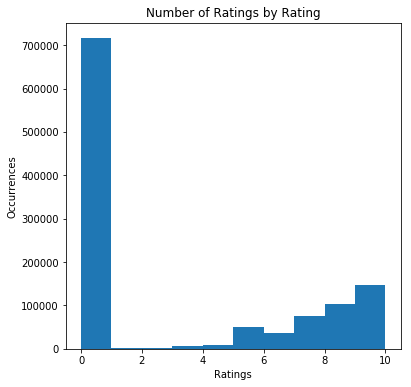

In [36]:
# Total ratings by rating #
fig = plt.figure(figsize=(6,6))
plt.hist(ratings_df['Book-Rating'],bins=10,width=1,rwidth=2,);
plt.xlabel('Ratings')
plt.ylabel('Occurrences')
plt.title('Number of Ratings by Rating')
plt.show()
plt.savefig('img/ratings_by_rating.png',dpi=300,figsize=(6,6))

<Figure size 432x288 with 0 Axes>

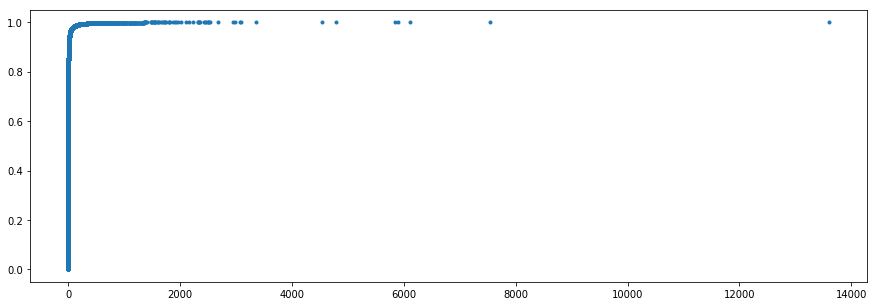

In [37]:
def ecdf(data):
    x = sorted(data)
    n = len(x)
    y = np.arange(1, n+1) / n
    return x,y,n


x,y,n = ecdf(ratings_df['User-ID'].value_counts())
plt.figure(figsize=(15,5))
plt.plot(x,y,linestyle='none',marker='.')
plt.show()

<h3>A few basic findings: First, the average rating is low on a 10 pt scale (2.9). After showing a historgram ofthe data we see almost 700k ratings of 0 (about 70% of the reviews). This may raises a couple analysis concerns and may be a bit troublesome</h3>

<h2>From the dataset</h2>
<p>"Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books."</p>

<h1>Initial Exploration Summary</h1>
<h2>This project provides some challenging aspects such fuzzy matching of authors and publishers, the over occurence of 0 as a rating for over 70% of books, and working some images into the recommendation matrix.</h2>

<h3>I'll probably approach this as a ranking task known as top-k recommendation with metrics MAP and NDCG. I took this from the url below</h3>

http://fastml.com/evaluating-recommender-systems/